## Unsupervised Methods ##

In [3]:
from __future__ import division
import pandas as pd
import numpy as np
import scipy as sp
import scipy.sparse as ss
import matplotlib.pyplot as plt
import pylab as pl
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering  #Ward
from sklearn.preprocessing import Binarizer
%matplotlib inline

In [4]:
# Dataset imported from R using write.csv(USArrests, "/tmp/USArrests.csv", row.names=FALSE)
# Each row in this dataset corresponds to one of the 50 US states.
usa_df = pd.read_csv("../data/USArrests.csv")
usa_df.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [5]:
usa_df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


### Principal Components ###

From the output of describe(), Assault has larger variance compared to other features. This would make Assault dominate the Principal component, so we should standardize the variables.

In [6]:
collist = usa_df.columns[1:]
X = usa_df[collist].values
Xdiv = np.linalg.norm(X, ord=2, axis=1)
usa_df[collist] = X / Xdiv[:, None]
usa_df.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,0.054031,0.966016,0.237411,0.086778
1,Alaska,0.036872,0.969739,0.176987,0.164081
2,Arizona,0.026439,0.959624,0.261122,0.101185
3,Arkansas,0.044528,0.961392,0.252998,0.098669
4,California,0.030657,0.940134,0.309972,0.138295


In [7]:
usa_df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.000000,50.000000,50.000000,50.000000
mean,0.040677,0.881704,0.409630,0.119341
std,0.015018,0.101645,0.166944,0.035642
min,0.012626,0.473419,0.132112,0.042620
25%,0.027485,0.850453,0.279234,0.092741
50%,0.039406,0.907323,0.395010,0.117441
75%,0.049811,0.952031,0.508929,0.139552
max,0.079346,0.989371,0.854213,0.207893


The variances are now comparable. Before doing PCA, we compute similarities between the states and represent as a heatmap. Since the matrix is already normalized, cosine similarity can be computed as a product of X and its transpose (the ||x|| and ||y|| are already built in because of the normalization).

In [8]:
X = usa_df[collist].values
cosim = np.matrix(X) * np.matrix(X.T)
cosim

matrix([[ 1.        ,  0.99503239,  0.99921399, ...,  0.97860009,
          0.7958759 ,  0.99326328],
        [ 0.99503239,  1.        ,  0.99437703, ...,  0.96276683,
          0.76073097,  0.9820459 ],
        [ 0.99921399,  0.99437703,  1.        , ...,  0.98283719,
          0.81122097,  0.99575786],
        ..., 
        [ 0.97860009,  0.96276683,  0.98283719, ...,  1.        ,
          0.90312329,  0.99546599],
        [ 0.7958759 ,  0.76073097,  0.81122097, ...,  0.90312329,
          1.        ,  0.86017937],
        [ 0.99326328,  0.9820459 ,  0.99575786, ...,  0.99546599,
          0.86017937,  1.        ]])

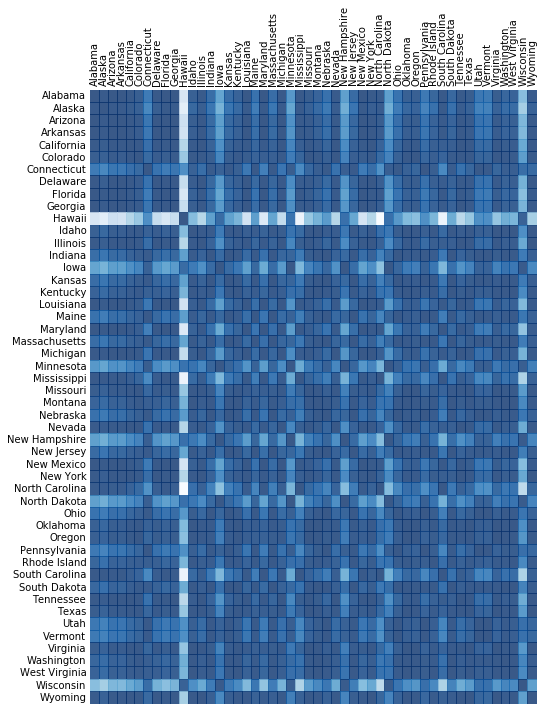

In [9]:
def heatmap(X, labels):
    """ Based on this stack overflow discussion """
    """ http://stackoverflow.com/questions/14391959/heatmap-in-matplotlib-with-pcolor """
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(X, cmap=plt.cm.Blues, alpha=0.8)
    # Format
    fig = plt.gcf()
    fig.set_size_inches(8, 11)
    # turn off the frame
    ax.set_frame_on(False)
    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(X.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(X.shape[1]) + 0.5, minor=False)
    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    # Set the labels
    ax.set_xticklabels(labels, minor=False)
    ax.set_yticklabels(labels, minor=False)
    # rotate the xticks
    plt.xticks(rotation=90)
    ax.grid(False)
    # Turn off all the ticks
    ax = plt.gca()
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

heatmap(np.array(cosim), usa_df["State"].values)

In [10]:
# PCA seems to consider each row as a component. So doing a PCA.fit(X) will decompose
# our 50x4 matrix to 2x4. So we need to fit the transpose of X (4x50) and transpose the 
# resulting principal components 2x50.
pca = PCA(n_components=2)
pca.fit(X.T)
print "Explained variance:", pca.explained_variance_ratio_
X_pr = pca.components_.T
X_pr[0:5, :]

Explained variance: [ 0.93412764  0.06465589]


array([[ 0.15422962, -0.12628851],
       [ 0.15000496, -0.17607116],
       [ 0.1550715 , -0.10258781],
       [ 0.15364218, -0.11332485],
       [ 0.14892486, -0.06991918]])

In [11]:
# Calculate cosine similarity using X_pr and plot a heat map
X_pdiv = np.linalg.norm(X_pr, ord=2, axis=1)
X_prn = X_pr / X_pdiv[:, None]
cosim_p = np.matrix(X_prn) * np.matrix(X_prn.T)
cosim_p

matrix([[ 1.        ,  0.98401382,  0.99483635, ...,  0.66265268,
         -0.39006555,  0.90240887],
        [ 0.98401382,  1.        ,  0.96085777, ...,  0.51868141,
         -0.54781484,  0.81124632],
        [ 0.99483635,  0.96085777,  1.        , ...,  0.73524112,
         -0.29459879,  0.94148013],
        ..., 
        [ 0.66265268,  0.51868141,  0.73524112, ...,  1.        ,
          0.43112418,  0.92068183],
        [-0.39006555, -0.54781484, -0.29459879, ...,  0.43112418,
          1.        ,  0.04475082],
        [ 0.90240887,  0.81124632,  0.94148013, ...,  0.92068183,
          0.04475082,  1.        ]])

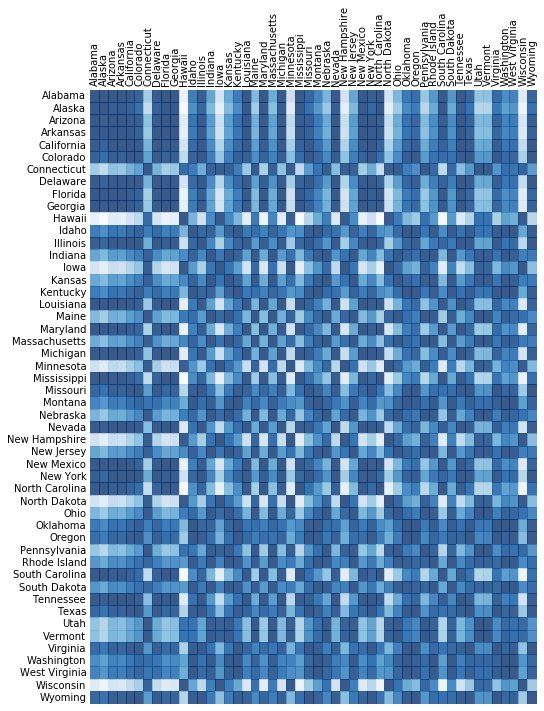

In [12]:
heatmap(np.array(cosim_p), usa_df["State"].values)

The resulting heatmap after PCA has more distinct similarities, which is expected, since PCA tends to highlight the differences. The R example shows a biplot. I couldn't find an example of a biplot in Matplotlib, and in any case, I didn't find the biplot to be as compelling a visual as a heatmap, so went for a heatmap instead.

### K-Means Clustering ###

For illustration and visualization purposes, the example is restricted to 2 dimensions.

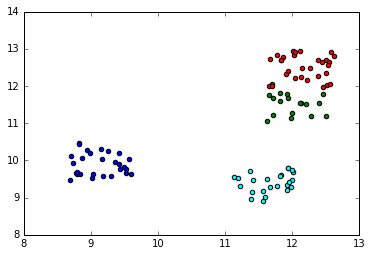

In [13]:
X = np.random.rand(100, 2)
X_mean = 8 + (4 * np.random.rand(4, 2))  # N(8,4)
which = np.random.choice(np.array([0,1,2,3]), size=100, replace=True)
for i in range(0, X.shape[0]):
    X[i] = X[i] + X_mean[which[i], :]

# Plot the points
fig, ax = plt.subplots()
ax.scatter(X[which == 0][:, 0], X[which == 0][:, 1], c='blue')
ax.scatter(X[which == 1][:, 0], X[which == 1][:, 1], c='green')
ax.scatter(X[which == 2][:, 0], X[which == 2][:, 1], c='red')
ax.scatter(X[which == 3][:, 0], X[which == 3][:, 1], c='cyan')

We now cluster these points using K-Means (we use the which values to evaluate the performance later).

[[ 28.   0.   0.   0.]
 [  0.  18.   0.   0.]
 [  0.   3.   0.  27.]
 [  0.   0.  24.   0.]]


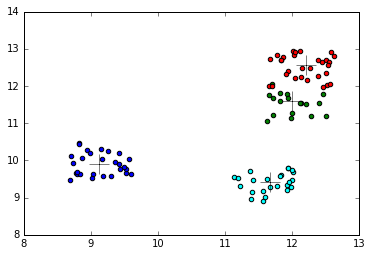

In [14]:
kmeans = KMeans(n_clusters=4, n_init=15)
kmeans.fit(X)
ypred = kmeans.predict(X)

# Print confusion matrix. Note that the matrix is not aligned because we don't know
# the correspondence between the assigned cluster and the generated cluster, but the
# matrix should show one high value per row and/or column.
confusion_matrix = np.zeros((4, 4))
for i in range(0, which.shape[0]):
    actual = which[i]
    predicted = ypred[i]
    confusion_matrix[actual, predicted] = confusion_matrix[actual, predicted] + 1
print confusion_matrix

# Plot points with cluster centers (marked with +)
fig, ax = plt.subplots()
ax.scatter(X[which == 0][:, 0], X[which == 0][:, 1], c='blue')
ax.scatter(X[which == 1][:, 0], X[which == 1][:, 1], c='green')
ax.scatter(X[which == 2][:, 0], X[which == 2][:, 1], c='red')
ax.scatter(X[which == 3][:, 0], X[which == 3][:, 1], c='cyan')
for cc in kmeans.cluster_centers_:
    ax.plot(cc[0], cc[1], marker='+', color='black', markersize=20)

### Hierarchical Clustering ###

We reuse the same data to demonstrate Hierarchical Clustering. R has many more options in this area than Scikit-Learn. The only algorithm available is Ward algorithm - one of the 7 methods available in R's hclust() function.

R also has a built-in plot() method which prints out the dendogram for the clustering. It is [possible to draw a dendogram](http://stackoverflow.com/questions/11917779/how-to-plot-and-annotate-hierarchical-clustering-dendrograms-in-scipy-matplotlib) using data returned 

In [16]:
# produce a connectivity matrix based on cosine similarity
norms = np.linalg.norm(X, ord=2, axis=1)
X_n = X / norms[:, None]
cosim = np.matrix(X_n) * np.matrix(X_n.T)
binarizer = Binarizer(threshold=0.5).fit_transform(cosim)
cosim_sparse = ss.csr_matrix(cosim)

# run the clustering
ward = AgglomerativeClustering(n_clusters=4, connectivity=cosim_sparse)
ypred = ward.fit_predict(X)

# compute the confusion matrix for hierarchical clustering
confusion_matrix = np.zeros((4, 4))
for i in range(0, which.shape[0]):
    actual = which[i]
    predicted = ypred[i]
    confusion_matrix[actual, predicted] = confusion_matrix[actual, predicted] + 1
confusion_matrix

array([[  0.,  28.,   0.,   0.],
       [  0.,   0.,   0.,  18.],
       [ 28.,   0.,   0.,   2.],
       [  0.,   0.,  24.,   0.]])